Guassian Mixture Model (GMM）& Expectation Maximization(EM) 
=============================

* Basic Concepts
------------------------------
> A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. 

* Math 
------------------------------
> Parameters: $k$ clusters, for $i$th cluster: Mean $\mu_i$, Variance $ \Sigma_i$, mixture coefficient $\alpha_i$, $\sum_{i=1}^{k}\alpha_i=1 $
$$ p(x)= \sum_{i=k}^{k}\alpha_i N(x\mid \mu_i.\Sigma_i) $$

> Equivalent :latent variable form:
$$ p(z=i)=\alpha_i \ \ (a)$$  
$$ p(x\mid z=i)=N(x\mid \mu_i,\Sigma_i) \ \ (b) $$
(a)Select a mixture componet with probability $\alpha$ and (b) Sample from that componets's Gaussian.

> Latent Variable： $z$  We observe x, but z is hidden.

* Alg (EM)
--------------------------------
Expectation maximization(EM) approach is used to maximize log likehood of GMM.


> #### i=1,2,$\cdots$,k clusters  &  j=1,2,$\cdots$,n examples

> ### Expectation (E-step): 

> $$ \gamma_{ji}=P(z_j=i\mid x_j)= \frac{P(z_j=i)P(x_j\mid z_j=i)}{P(x_j)}=\frac{\alpha_i P(x_j\mid \mu_i,\Sigma_i)}{\sum_{l=1}^{k}\alpha_l P(x_j\mid \mu_l,\Sigma_l)} \ \ \ (1) $$ 
for Guassian distribution
$$ P(x\mid \mu,\Sigma)= \frac{1}{(2\pi)^{\frac{n}{2}} |\Sigma|^{\frac{1}{2}}} exp(-\frac{1}{2} (x-\mu)^T \Sigma^{-1}(x-\mu))  \ \ \ (2) $$

> ### Maximization (M-step):

> $$ \mu_i=\frac{\sum_{j=1}^{n}\gamma_{ji}x_j}{\sum_{j=1}^{n}\gamma_{ji}}  \ \ \ (3)$$  
$$ \Sigma_i=\frac{\sum_{j=1}^{n}\gamma_{ji}(x_j-\mu_i)(x_j-\mu_i)^T}{\sum_{j=1}^{n}\gamma_{ji}}  \ \ \ (4)$$  
$$ \mu_i=\frac{1}{n}\sum_{j=1}^{n}\gamma_{ji}  \ \ \ (5)$$


* Implementation:
--------------------------------

In [186]:
#----------- Implement EM algorithm for GMM ----------#

import numpy as np

# parameter:
# k clusters (should be specified)
# max_steps (max iteration)
class GMM:
    def __init__(self,k,max_steps):
        self.k=k
        self.nsteps=max_steps
        # initial alpha
        self.alpha=np.zeros((k))+ 1.0/k
    
    def pdf(self,x,d,mu,sigma):
        # equation (2)
        p_x=1/(np.power((2*np.pi),d/2)*np.linalg.det(sigma) ** 0.5)*np.exp(-.5 * np.dot(np.dot(x-mu, np.linalg.inv(sigma)), (x-mu).T))
        return p_x
        
    def train(self,X):
        # X: n examples x d features           
        [n,d]=X.shape
        
        # initial mu and sigma
        # mu: kxd
        # sigma: kxdxd
        
        #self.mu=np.random.uniform(0,1,(self.k,d)) --> easy to overflow 
        #self.sigma=np.random.uniform(0,1,(self.k,d,d)) 
        self.mu=X[np.random.randint(n,size=self.k),:]
        self.sigma=np.zeros((self.k,d,d)) 
        sigma_tmp=np.diag(np.diag(np.zeros((d,d))+0.1))
        for i in range(self.k):
            self.sigma[i,:,:]=sigma_tmp
        
        mu_history=np.zeros((self.nsteps,self.k,d))
        
        for l in range(self.nsteps):
            
            #-- E-step --#
            gamma = np.zeros((self.k,n))
            
            # equation (1)
            for j in range(n):
                for i in range(self.k):
                    gamma[i,j]=self.alpha[i]*self.pdf(X[j,:],d,self.mu[i,:],self.sigma[i,:,:])
            gamma=gamma/np.sum(gamma,axis=0)
            
            #-- M-step --#
            g_sum = np.sum(gamma,axis=1)

            for i in range(self.k):
                mu_history[l,i,:] = self.mu[i,:]
                
                # equation (3)
                self.mu[i,:] = np.dot(gamma[i,:],X) / g_sum[i]
                
                # equation (4)
                self.sigma[i,:,:] = np.zeros((d,d))
                for j in range(n):
                    self.sigma[i,:,:] += gamma[i,j] * np.outer(X[j,:] - self.mu[i,:], X[j,:] - self.mu[i,:])

                self.sigma[i,:,:] = self.sigma[i,:,:] / g_sum[i]
                
                # equation (5)
                self.alpha[i] = g_sum[i]/n
                
            #-- stop condition --#
            # condition 1:
            
            threshold=1e-7
            mu_diff=np.sum(np.abs(self.mu-mu_history[l-1,:,:]))
            if mu_diff<threshold:
                print 'mu_diff: ',mu_diff
                break
            
            # condition 2: #
            #....
            
            #print 'step',l,':  mu_diff=',mu_diff     
        return mu_history
                
    def predict(self,X):
        [n,d]=X.shape
        p_X=np.zeros((n,1))

        for j in range(n):
                for i in range(self.k):
                    tmp=self.pdf(X[j,:],d,self.mu[i,:],self.sigma[i,:,:])
                    p_X[j] +=self.alpha[i]*self.pdf(X[j,:],d,self.mu[i,:],self.sigma[i,:,:])
        
        # optimization: 2 loops to 1 loop
        #for i in range(self.k):
            #p_X += self.alpha[i]*self.pdf(X,d,np.tile(self.mu[i,:],n),self.sigma[i,:,:])
        
        return p_X
            

* Project:
--------------------------------
Data path 
> ./Datas/GMM-EM

Data Description
> 
train.txt: Training data.   
dev.txt: Development data for tuning and self testing.   
test.txt: Evaluation data for testing the model. Only   

Data Format

> Each line of the data file represent a sample in the below format:  
> Feature-Dim1   Feature-Dim2    Class-Label

> Note that Both features and labels are given for train.txt and dev.txt. 
Only features are given for test.txt.

+ ### Step 1: Analyze the training data ###

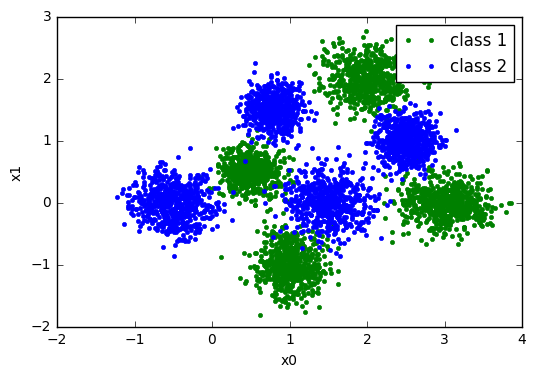

In [187]:
#---------- Data Visualization -------------#

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

file_pre="./Datas/GMM-EM/"

def loadData(txt_name):
    file_name=file_pre+txt_name

    f=open(file_name,'r')
    lines=f.readlines()
    f.close()
    
    n=len(lines)

    # intialize x and y
    X=np.zeros((n,2))
    y=np.zeros((n,1))

    # get x and y from txt
    for index,line in enumerate(lines):
        tmp,y[index]=str.split(line.strip(),'  ')
        X[index,:]=str.split(tmp.strip(),' ')
    return X,y

# prepare training data
X,y=loadData('train.txt')

# split data to two classes
# y=1 and y=2
X_1=X[np.where(y==1)[0],:]
X_2=X[np.where(y==2)[0],:]

# plot
plt.plot(X_1[:,0],X_1[:,1],'g.')
plt.plot(X_2[:,0],X_2[:,1],'b.')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(['class 1', 'class 2'])


> SO, we can train 2 GMMs, and each has 4 clusters.

+ ### Step 2: train GMMs ###

In [188]:
#----- train GMMs for training data ------#

# initial GMM
k=4
max_steps=50

gmm_1= GMM(k,max_steps)
gmm_2= GMM(k,max_steps)

# train GMM
print '-------------class 1-------------'
mu_his_1=gmm_1.train(X_1)
print '-------------class 2-------------'
mu_his_2=gmm_2.train(X_2)

-------------class 1-------------
mu_diff:  7.0675640014e-08
-------------class 2-------------
mu_diff:  8.93386694881e-08


> We can see the the difference between mu and the last mu is decreasing step by step.

+ ### Step 3: Analyze the result. ### 


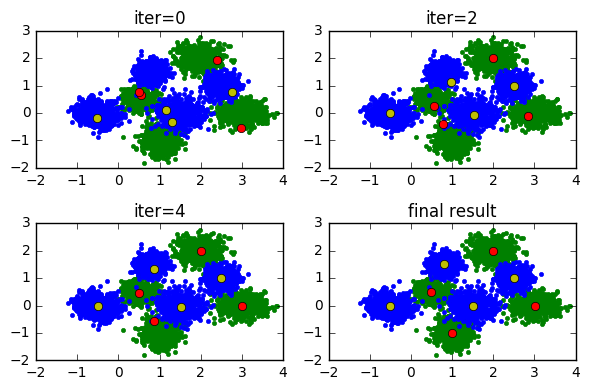

In [192]:
# plot
def plotData():
    plt.plot(X_1[:,0],X_1[:,1],'g.')
    plt.plot(X_2[:,0],X_2[:,1],'b.')
    #plt.xlabel('x0')
    #plt.ylabel('x1')
    #plt.legend(['class 1', 'class 2'])

def plotMu(l):
    plt.plot(mu_his_1[l,:,0],mu_his_1[l,:,1],'ro')
    plt.plot(mu_his_2[l,:,0],mu_his_2[l,:,1],'yo')


# see the GMM parameter tuning process

plt.subplot(2,2,1)
plotData()
plotMu(0)
plt.title('iter=0')

l=2
plt.subplot(2,2,2)
plotData()
plotMu(l)
plt.title('iter='+str(l))

l=4
plt.subplot(2,2,3)
plotData()
plotMu(l)
plt.title('iter='+str(l))

plt.subplot(2,2,4)
plotData()
plt.title('final result')
plt.plot(gmm_1.mu[:,0],gmm_1.mu[:,1],'ro')
plt.plot(gmm_2.mu[:,0],gmm_2.mu[:,1],'yo')

plt.tight_layout()

> In the figure above, the GMM's mu is closer to the real center of data ditribution by iteration.  

> Different initial parameters generated by the same initial method have different converge speed. Class 1 is faster than Class 2.  

> In the final figure, the GMM's mu looks just at the real center of data, so the training result may be good.

+ ### Step 4: Validate the trained GMMs ###


In [196]:
# ---------- predict label in dev.txt data by trained GMMs ----------#

X,y=loadData('dev.txt')
p_X_1= gmm_1.predict(X) # probability in class 1
p_X_2= gmm_2.predict(X) # probability in class 2

n=X.shape[0]
y_p= np.ones((n,1))
y_p[p_X_1<p_X_2]=2 # if probability in class 2 is greater than in class 1, this instance belongs to class 2.

index=(y_p==y)  # compare with the real label
acc=len(index)*100.0/n

print '* Accurancy in validation set: ',acc,'%'

* Accurancy in validation set:  100.0 %


> 100% in validation set, so the trained model is very good. We can use it to predict our test data.

+ ### Step 5: Predict the label of the test set  ###


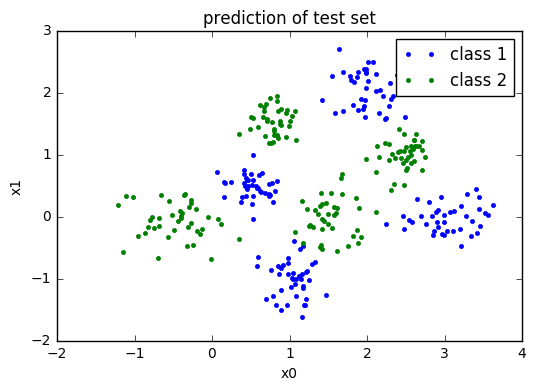

In [195]:
# ---------- predict label  ----------#
file_name=file_pre+'test.txt'
f=open(file_name,'r')
lines=f.readlines()

n=len(lines)

# intialize x and predicted y
X=np.zeros((n,2))
y_p=np.ones((n,1))

# get x from txt
for index,line in enumerate(lines):
    X[index,:]=str.split(line.strip(),' ')


# predict by GMM
p_X_1= gmm_1.predict(X) # probability in class 1
p_X_2= gmm_2.predict(X) # probability in class 2

y_p[p_X_1<p_X_2]=2 # if probability in class 2 is greater than in class 1, this instance belongs to class 2.


# save result
file_name=file_pre+'test_result.txt'
f=open(file_name,'w')
for i in range(n):
    line='%f %f  %d\n' % (X[i,0], X[i,1], y_p[i])
    f.writelines(line);
f.close()

# visualization
X_1=X[np.where(y_p==1)[0],:]
X_2=X[np.where(y_p==2)[0],:]

plt.plot(X_1[:,0],X_1[:,1],'b.')
plt.plot(X_2[:,0],X_2[:,1],'g.')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(['class 1', 'class 2'])
plt.title('prediction of test set')

* Pros and cons
----------------------------------

+ Pros

> Speed: It is the fastest algorithm for learning mixture models  

> Agnostic:	As this algorithm maximizes only the likelihood, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.

+ Cons

> Singularities: When one has insufficiently many points per mixture, estimating the covariance matrices becomes difficult, and the algorithm is known to diverge and find solutions with infinite likelihood unless one regularizes the covariances artificially.

> Number of components: This algorithm will always use all the components it has access to, needing held-out data or information theoretical criteria to decide how many components to use in the absence of external cues.

* About my implementation
----------------------------------
+ The tuning process and result is very sensitive to the initial parameters. 

> If the initial methods is uniform (used), it's easy to overflow.   
> The present initial method is from Ref$^1$, but still cann't converge sometimes.

+ There still retain some places to optimize

> The stop condition. I use the diff between two mu, others also can be done.     
> In the prediction block, matrix processing can be optimized.



* Ref:
--------------------------------
+ 机器学习 by 周志华
+ 统计学习 by 李航
+ https://www.cs.utah.edu/~piyush/teaching/EM_algorithm.pdf
+ http://scikit-learn.org/stable/modules/mixture.html
+ https://www.youtube.com/watch?v=qMTuMa86NzU
+ https://github.com/stober/gmm

### Thanks for reading   (◠‿◠✿)